In [1]:
import chess.pgn
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import json
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import torch
from torch.amp import autocast, GradScaler
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from functools import partial
import numpy as np
import chess

pgn_path = "data/all_lichess_elite_games.pgn"

In [2]:
# def count_games(pgn_path):
#     count = 0
#     with open(pgn_path, 'r', encoding='utf-8') as f:
#         while True:
#             game = chess.pgn.read_game(f)
#             if game is None:
#                 break
#             count += 1
#             if count % 1000000 == 0:
#                 print(f"{count} games counted...")
#     return count
#
# total_games = count_games(pgn_path)
# print(f"Total games: {total_games}")

### Data understanding

In this notebook, I will analyze the dataset from lichess. This dataset is an elite dataset were only games from high rated titled players are included. This dataset does not include bullet (1 or 2 minute games), but only classical, rapid and blitz games. There is a total of around 3.8 million games in the set. The dataset is in PGN format, which is a standard format for chess games. Each game is stored in a single line with the moves and metadata. This differs from FEN were only a single position is stored. The actual game is stored as standard algebraic notation (SAN) move list. This dataset only has the game itself plus some information about the game. Termination is also included, which stores how the game has ended. Normal is just by regular rules of chess (checkmate, stalemate, resignation and a couple more) and when it's not normal it's either on time or something weird happened like rule violations, abandonment of the game or the PGN is broken. ECO codes are included which show the opening played in the game, in the other opening tab it shows the variation inside the opening as well.

[Event "Rated Blitz game"]
[Date "????.??.??"]
[Round "?"]
[White "skopje123"]
[Black "NIGHTGUEST"]
[Result "0-1"]
[WhiteElo "2361"]
[BlackElo "2429"]
[ECO "D02"]
[Opening "Queen's Gambit Refused: Baltic Defense"]
[TimeControl "180+0"]
[UTCDate "2015.08.31"]
[UTCTime "22:00:17"]
[Termination "Normal"]
[WhiteRatingDiff "-9"]
[BlackRatingDiff "+9"]

1. d4 d5 2. c4 Bf5 3. cxd5 Bxb1 4. Rxb1 Qxd5 5. e3 Nc6 6. Ne2 e5 7. Nc3 Bb4 8. Bd2 Bxc3 9. bxc3 exd4 10. cxd4 Nf6 11. Rb5 Qxa2 12. Rxb7 O-O 13. Be2 Ne4 14. Bf3 Nxd2 15. Bxc6 Qa6 16. Qxd2 Qxc6 17. Rb1 Qxg2 18. Ke2 Qg4+ 19. Kf1
Rfb8 20. Rc1 a5 21. Rg1 Qh3+ 22. Rg2 a4 23. Rxc7 a3 24. Rc2 Rb1+ 25. Rc1 a2 26. Ke2 Rxc1 0-1

### Data analysis / cleaning

I'm starting with 10000 games for testing, but I will increase this number later. I will only consider games that are longer than 14 half-moves(7 for each side) and shorter than 200 half-moves(100 for each side) as the longer games are probably in time constraint and the shorter games are probably were aborted or not finished in the dataset. As for the timecontrol I will keep it like this for now but might change it to only rapid or longer time controls as there are a lot of mistakes made in 3+0 games.

In [3]:
feature_data = [
    ("Event", "Rated Blitz game", "Type of game or tournament."),
    ("Date", "????.??.??", "Date of the event (may be missing)."),
    ("Round", "?", "Round number (often unknown in online games)."),
    ("White", "skopje123", "Username of the White player."),
    ("Black", "NIGHTGUEST", "Username of the Black player."),
    ("Result", "0-1", "Game outcome: 1-0 (White wins), 0-1 (Black wins), 1/2-1/2 (Draw)."),
    ("WhiteElo", "2361", "White player's rating before the game."),
    ("BlackElo", "2429", "Black player's rating before the game."),
    ("ECO", "D02", "ECO opening code (standardized)."),
    ("Opening", "Queen's Gambit Refused: Baltic Defense", "Full name of the opening variation."),
    ("TimeControl", "180+0", "Base time (s) + increment (s)."),
    ("UTCDate", "2015.08.31", "Date the game started (UTC)."),
    ("UTCTime", "22:00:17", "Time the game started (UTC)."),
    ("Termination", "Normal", "How the game ended (Normal, Time forfeit, etc.)."),
    ("WhiteRatingDiff", "-9", "Rating change for White."),
    ("BlackRatingDiff", "+9", "Rating change for Black."),
    ("Moves", "1. d4 d5 2. c4 ...", "List of moves from the PGN body in Standard Algebraic Notation (SAN).")
]

feature_df = pd.DataFrame(feature_data, columns=["Feature", "Example", "Description"])

display(feature_df)

,Feature,Example,Description
0,Event,Rated Blitz game,Type of game or tournament.
1,Date,????.??.??,Date of the event (may be missing).
2,Round,?,Round number (often unknown in online games).
3,White,skopje123,Username of the White player.
4,Black,NIGHTGUEST,Username of the Black player.
5,Result,0-1,"Game outcome: 1-0 (White wins), 0-1 (Black win..."
6,WhiteElo,2361,White player's rating before the game.
7,BlackElo,2429,Black player's rating before the game.
8,ECO,D02,ECO opening code (standardized).
9,Opening,Queen's Gambit Refused: Baltic Defense,Full name of the opening variation.


In [4]:
def analyze_pgn_file(path, max_games=10000, min_halfmoves=15, max_halfmoves=200):
    result_counter = Counter()
    first_move_counter = Counter()
    game_lengths = []
    time_controls = Counter()
    opening_counter = Counter()
    eco_counter = Counter()
    termination_counter = Counter()
    lengths_by_result = {"1-0": [], "0-1": [], "1/2-1/2": []}

    with open(path, encoding='utf-8') as f:
        for i in range(max_games):
            game = chess.pgn.read_game(f)
            if game is None:
                break

            moves = list(game.mainline_moves())
            plies = len(moves)

            if plies < min_halfmoves or plies > max_halfmoves:
                continue

            opening_name = game.headers.get("Opening", "Unknown")
            opening_counter[opening_name] += 1

            eco = game.headers.get("ECO", "Unknown")
            eco_counter[eco] += 1

            termination = game.headers.get("Termination", "Unknown")
            termination_counter[termination] += 1

            result = game.headers.get("Result", "unknown")
            result_counter[result] += 1

            if result in lengths_by_result:
                lengths_by_result[result].append(plies)

            tc = game.headers.get("TimeControl", "?")
            time_controls[tc] += 1

            game_lengths.append(plies)

            board = game.board()
            if moves:
                first_move = board.san(moves[0])
                first_move_counter[first_move] += 1

    return result_counter, first_move_counter, game_lengths, time_controls, opening_counter, eco_counter, termination_counter, lengths_by_result

def categorize_time_control(tc_str):
    if "+" not in tc_str or tc_str == "?":
        return "Unknown"
    try:
        base, inc = tc_str.split("+")
        base = int(base)
        if base < 180:
            return "Bullet"
        elif base < 600:
            return "Blitz"
        elif base < 1800:
            return "Rapid"
        else:
            return "Classical"
    except:
        return "Unknown"

results, first_moves, lengths, time_controls, openings, ecos, terminations, lengths_by_result = analyze_pgn_file(pgn_path)

results_df = pd.DataFrame(results.items(), columns=["Result", "Count"]).sort_values(by="Count", ascending=False)
first_moves_df = pd.DataFrame(first_moves.most_common(10), columns=["First Move", "Frequency"])
tc_df = pd.DataFrame(time_controls.items(), columns=["Time Control", "Count"]).sort_values(by="Count", ascending=False)

tc_df["Category"] = tc_df["Time Control"].apply(categorize_time_control)
tc_category_df = tc_df.groupby("Category")["Count"].sum().reset_index().sort_values(by="Count", ascending=False)

print("Game Result Distribution:")
display(results_df)

print("Most Common First Moves:")
display(first_moves_df)

print("Time Control Frequencies:")
display(tc_df)

print("Time Control Categories:")
display(tc_category_df)

avg_length = sum(lengths) / len(lengths)
print(f"Average Game Length (plies): {avg_length:.2f}")

openings_df = pd.DataFrame(openings.most_common(10), columns=["Opening", "Count"])
print("Most Common Full Openings:")
display(openings_df)

eco_df = pd.DataFrame(ecos.most_common(10), columns=["ECO Code", "Count"])
print("Most Common ECO Codes:")
display(eco_df)

termination_df = pd.DataFrame(terminations.items(), columns=["Termination", "Count"]).sort_values(by="Count", ascending=False)
print("Game Termination Types:")
display(termination_df)

Game Result Distribution:


,Result,Count
0,1-0,4701
1,0-1,4408
2,1/2-1/2,825


Most Common First Moves:


,First Move,Frequency
0,e4,4711
1,d4,3448
2,Nf3,794
3,c4,517
4,b3,123
5,g3,93
6,b4,64
7,Nc3,46
8,f4,39
9,e3,37


Time Control Frequencies:


,Time Control,Count,Category
0,180+0,8647,Blitz
7,180+1,360,Blitz
5,180+2,209,Blitz
2,300+0,175,Blitz
6,60+3,132,Bullet
18,120+2,116,Bullet
9,240+0,93,Blitz
3,180+3,42,Blitz
15,480+0,34,Blitz
24,600+0,12,Rapid


Time Control Categories:


,Category,Count
0,Blitz,9633
1,Bullet,269
3,Rapid,31
2,Classical,1


Average Game Length (plies): 82.32
Most Common Full Openings:


,Opening,Count
0,Scandinavian Defense: Main Line,236
1,Scandinavian Defense: Mieses-Kotroc Variation,218
2,Trompowsky Attack,180
3,Sicilian Defense: Alapin Variation,144
4,Scandinavian Defense,142
5,"Trompowsky Attack: Classical Defense, Big Cent...",106
6,"Scandinavian Defense: Main Line, Mieses Variation",97
7,Scandinavian Defense: Gubinsky-Melts Defense,96
8,"Sicilian Defense: Alapin Variation, Barmen Def...",95
9,Modern Defense,91


Most Common ECO Codes:


,ECO Code,Count
0,B01,961
1,A45,471
2,B22,273
3,A40,263
4,A00,241
5,D02,235
6,B06,223
7,A04,220
8,B12,186
9,A46,182


Game Termination Types:


,Termination,Count
0,Normal,7596
1,Time forfeit,2338


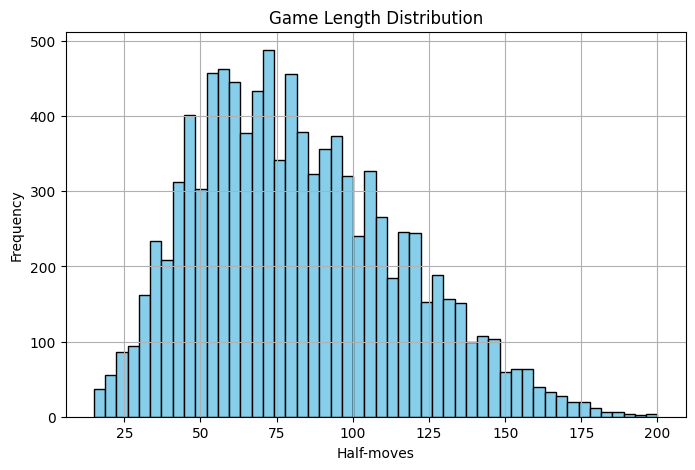

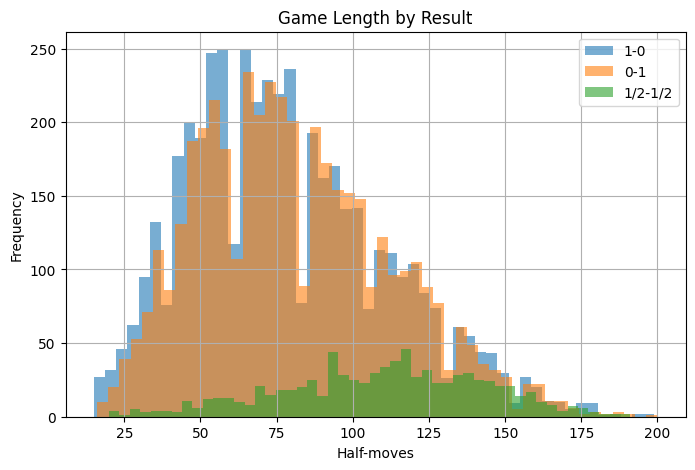

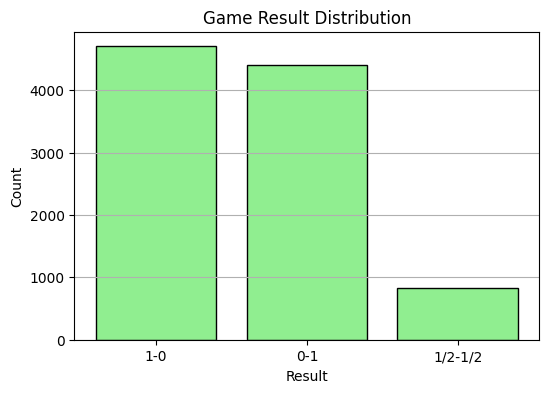

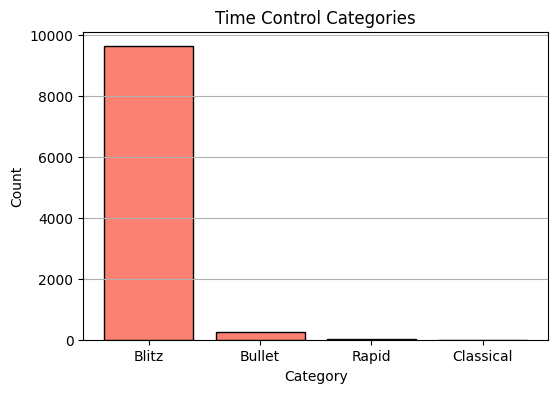

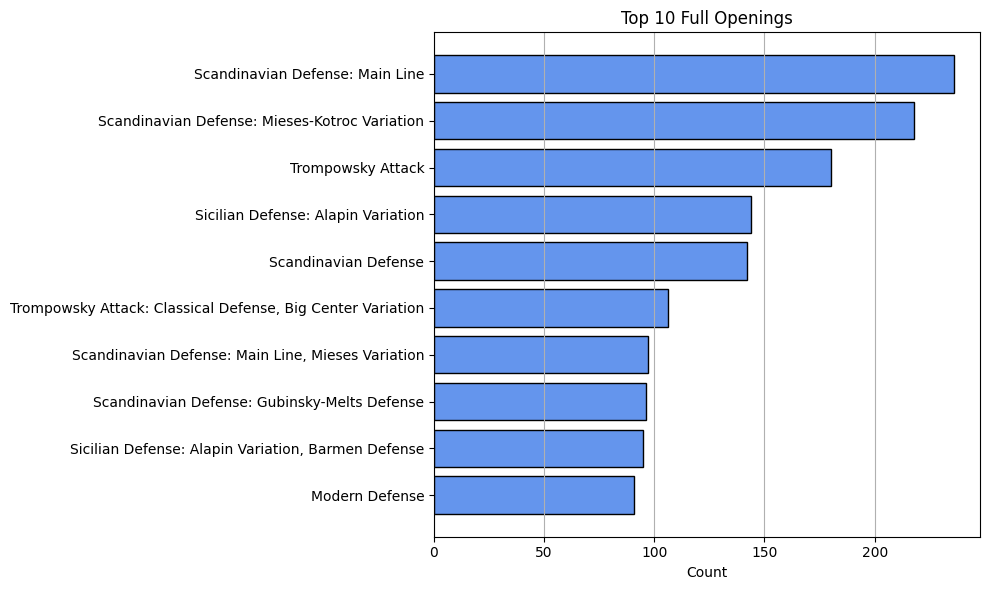

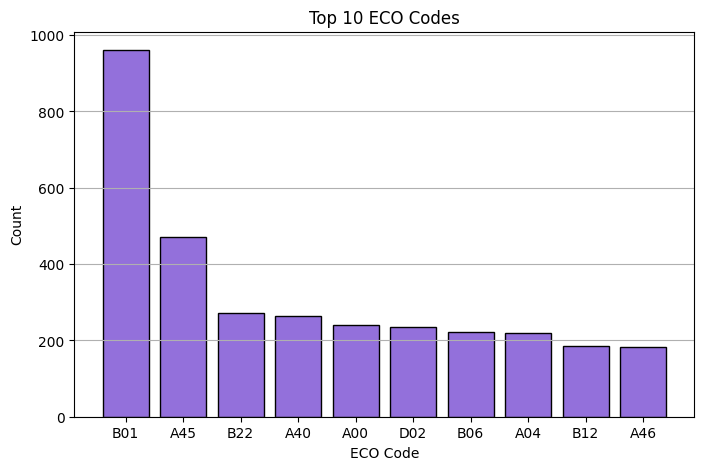

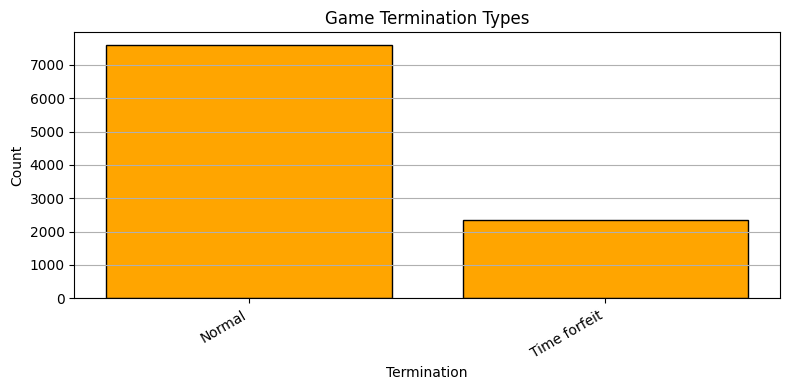

In [5]:
plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Game Length Distribution")
plt.xlabel("Half-moves")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
for result, length_list in lengths_by_result.items():
    if length_list:
        plt.hist(length_list, bins=50, alpha=0.6, label=result)
plt.title("Game Length by Result")
plt.xlabel("Half-moves")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(results_df["Result"], results_df["Count"], color="lightgreen", edgecolor="black")
plt.title("Game Result Distribution")
plt.xlabel("Result")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(tc_category_df["Category"], tc_category_df["Count"], color="salmon", edgecolor="black")
plt.title("Time Control Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(openings_df["Opening"][::-1], openings_df["Count"][::-1], color="cornflowerblue", edgecolor="black")
plt.title("Top 10 Full Openings")
plt.xlabel("Count")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(eco_df["ECO Code"], eco_df["Count"], color="mediumpurple", edgecolor="black")
plt.title("Top 10 ECO Codes")
plt.xlabel("ECO Code")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(termination_df["Termination"], termination_df["Count"], color="orange", edgecolor="black")
plt.title("Game Termination Types")
plt.xlabel("Termination")
plt.ylabel("Count")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Modeling

To actually be able to use this data for modeling I will need to convert the data to a format that is usable for machine learning. I came to the conclusion that I would need to make groups of moves and the last move will be the target variable. So lets say this is a group: E4, E5, Nf3, Nc6. The target variable would be Nc6 and the input variables would be E4, E5, Nf3. Maybe adding the opening as a feature could be useful as well, but I will start without.
For the input I will be using a fixed length of 5 moves to start off, but I will be tuning this later.

In [6]:
def extract_move_sequence_dataset(pgn_path, json_output_path, max_games=10000, min_halfmoves=15, max_halfmoves=200, fixed_input_len=20):
    dataset = []
    with open(pgn_path, encoding='utf-8') as f:
        for game_idx in range(max_games):
            game = chess.pgn.read_game(f)
            if game is None:
                break

            board = game.board()
            moves = []
            for move in game.mainline_moves():
                moves.append(board.san(move))
                board.push(move)

            if len(moves) < min_halfmoves or len(moves) > max_halfmoves:
                continue

            # Create input and target variable groups
            for i in range(fixed_input_len, len(moves)):
                input_sequence = moves[i - fixed_input_len:i]
                target_move = moves[i]
                
                dataset.append({
                    "input": input_sequence,
                    "target": target_move
                })

    with open(json_output_path, "w", encoding="utf-8") as out_file:
        json.dump(dataset, out_file, ensure_ascii=False, indent=2)

    print(f"Done. Saved {len(dataset)} samples to {json_output_path}")

json_output_path = "../Chess_visualization/data/lichess_move_dataset.json"
extract_move_sequence_dataset(pgn_path, json_output_path, max_games=10000)

Done. Saved 619257 samples to data/lichess_move_dataset.json


Because models need numbers to train on, I will need to convert the moves to numbers. I will use a dictionary that will map each move to a unique int. This allows me to convert the moves to numbers and back again. So the input will be numbers and the target variables as well, but the output will be the move in SAN notation.

In [7]:
def build_vocab(json_path, specials=("<PAD>", "<UNK>")):
    with open(json_path, encoding="utf-8") as f:
        data = json.load(f)

    move_counter = Counter()
    for sample in data:
        move_counter.update(sample["input"])
        move_counter.update([sample["target"]])

    # Actual chess moves, sorted for reproducibility
    moves = sorted(move_counter.keys())

    # Prepend special tokens
    tokens = list(specials) + moves

    vocab = {tok: i for i, tok in enumerate(tokens)}
    return vocab

## Model Selection

This is a classification problem, where I need to classify the next move based on a sequence of previous moves. For this I think a Long Short-Term Memory(LSTM) model looks like a good initial choice, LSTMs are designed to handle sequential data and can capture patters over time, hopefully like opening structures or tactical motifs.

In [8]:
class ChessMoveDataset(Dataset):
    def __init__(self, json_path, vocab):
        with open(json_path, encoding="utf-8") as f:
            self.samples = json.load(f)
        self.vocab = vocab

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_ids = [self.vocab[move] for move in sample["input"]]
        target_id = self.vocab[sample["target"]]
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(target_id, dtype=torch.long)

In [9]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        hidden_dim=512,
        num_layers=3,
        dropout=0.2,
        pad_idx=0
    ):

        super().__init__()
        self.pad_idx   = pad_idx
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, lengths=None):
        emb = self.embedding(x)

        if lengths is not None:
            packed = pack_padded_sequence(
                emb, lengths.cpu(),
                batch_first=True, enforce_sorted=False)
            _, (h_n, _) = self.lstm(packed)
        else:
            _, (h_n, _) = self.lstm(emb)

        logits = self.fc(h_n[-1])
        return logits

In [10]:
def collate(batch, pad_idx):
    """batch = list[(LongTensor seq, LongTensor target)]"""
    seqs, targets = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs])

    # left-pad or right-pad—here we right-pad
    seqs_padded = pad_sequence(seqs, batch_first=True,
                               padding_value=pad_idx)

    return seqs_padded, lengths, torch.tensor(targets)

In [11]:
def evaluate_model(model, loader, device):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = corr1 = corr3 = corr5 = n = 0

    with torch.no_grad():
        for x, lengths, y in loader:
            x, lengths, y = x.to(device, non_blocking=True), lengths.to(device), y.to(device, non_blocking=True)
            logits = model(x, lengths)
            loss   = loss_fn(logits, y)
            total_loss += loss.item()

            topk = logits.topk(5, dim=1).indices      # (B,5)
            eq   = topk.eq(y.unsqueeze(1))
            corr1 += eq[:, :1].sum().item()
            corr3 += eq[:, :3].sum().item()
            corr5 += eq.sum().item()
            n     += y.size(0)

    return total_loss/len(loader), corr1/n, corr3/n, corr5/n


In [12]:
def train_model(model, train_loader, test_loader,
                epochs=20, patience=3, save_best_path=None,
                base_lr=0.001 * math.sqrt( 16384 / 1024 ), use_amp=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
    scaler    = GradScaler(enabled=use_amp)
    loss_fn   = torch.nn.CrossEntropyLoss()

    history, best_loss, no_improve = {}, float("inf"), 0
    for k in ["train_loss", "test_loss",
              "test_acc", "test_acc_top3", "test_acc_top5"]:
        history[k] = []

    for epoch in range(epochs):
        # -------- train --------
        model.train()
        running = 0.0
        for x, lengths, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, lengths, y = (
                x.to(device, non_blocking=True),
                lengths.to(device, non_blocking=True),
                y.to(device, non_blocking=True)
            )

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=use_amp):
                logits = model(x)
                loss   = loss_fn(logits, y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()

        avg_train = running / len(train_loader)

        # -------- eval ---------
        test_loss, a1, a3, a5 = evaluate_model(model, test_loader, device)
        history["train_loss"].append(avg_train)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(a1)
        history["test_acc_top3"].append(a3)
        history["test_acc_top5"].append(a5)

        print(f"Epoch {epoch+1}: "
              f"Train {avg_train:.4f} | Test {test_loss:.4f} "
              f"| Top-1 {a1:.2%} Top-3 {a3:.2%} Top-5 {a5:.2%}")

        # -------- early stop ---
        if test_loss < best_loss:
            best_loss, no_improve = test_loss, 0
            if save_best_path:
                torch.save(model.state_dict(), save_best_path)
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping (no improvement {patience} epochs)")
                break

    return history

Using device: cuda


Epoch 1/100: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


Epoch 1: Train 6.7428 | Test 6.6074 | Top-1 0.67% Top-3 2.05% Top-5 3.39%


Epoch 2/100: 100%|██████████| 31/31 [00:06<00:00,  4.49it/s]


Epoch 2: Train 6.5914 | Test 6.5431 | Top-1 0.87% Top-3 2.56% Top-5 3.93%


Epoch 3/100: 100%|██████████| 31/31 [00:06<00:00,  4.70it/s]


Epoch 3: Train 6.4512 | Test 6.4031 | Top-1 1.14% Top-3 2.77% Top-5 4.29%


Epoch 4/100: 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


Epoch 4: Train 6.3733 | Test 6.3675 | Top-1 1.24% Top-3 2.87% Top-5 4.57%


Epoch 5/100: 100%|██████████| 31/31 [00:06<00:00,  4.55it/s]


Epoch 5: Train 6.3470 | Test 6.3509 | Top-1 1.24% Top-3 3.08% Top-5 4.75%


Epoch 6/100: 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


Epoch 6: Train 6.3264 | Test 6.3261 | Top-1 1.33% Top-3 3.20% Top-5 4.97%


Epoch 7/100: 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


Epoch 7: Train 6.2969 | Test 6.2996 | Top-1 1.34% Top-3 3.40% Top-5 5.25%


Epoch 8/100: 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


Epoch 8: Train 6.2618 | Test 6.2635 | Top-1 1.42% Top-3 3.52% Top-5 5.49%


Epoch 9/100: 100%|██████████| 31/31 [00:06<00:00,  4.85it/s]


Epoch 9: Train 6.2123 | Test 6.1886 | Top-1 1.57% Top-3 4.14% Top-5 6.45%


Epoch 10/100: 100%|██████████| 31/31 [00:06<00:00,  4.65it/s]


Epoch 10: Train 6.0953 | Test 6.0354 | Top-1 1.92% Top-3 5.08% Top-5 8.01%


Epoch 11/100: 100%|██████████| 31/31 [00:06<00:00,  4.78it/s]


Epoch 11: Train 5.9573 | Test 5.9275 | Top-1 2.31% Top-3 6.00% Top-5 9.19%


Epoch 12/100: 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


Epoch 12: Train 5.8608 | Test 5.8529 | Top-1 2.55% Top-3 6.63% Top-5 10.24%


Epoch 13/100: 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]


Epoch 13: Train 5.7764 | Test 5.7743 | Top-1 2.87% Top-3 7.37% Top-5 11.09%


Epoch 14/100: 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


Epoch 14: Train 5.6939 | Test 5.7145 | Top-1 3.06% Top-3 7.95% Top-5 11.97%


Epoch 15/100: 100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


Epoch 15: Train 5.6155 | Test 5.6434 | Top-1 3.64% Top-3 8.91% Top-5 13.21%


Epoch 16/100: 100%|██████████| 31/31 [00:06<00:00,  4.57it/s]


Epoch 16: Train 5.5455 | Test 5.5819 | Top-1 3.98% Top-3 9.59% Top-5 14.02%


Epoch 17/100: 100%|██████████| 31/31 [00:06<00:00,  4.71it/s]


Epoch 17: Train 5.4782 | Test 5.5318 | Top-1 4.41% Top-3 10.30% Top-5 15.01%


Epoch 18/100: 100%|██████████| 31/31 [00:07<00:00,  4.35it/s]


Epoch 18: Train 5.4089 | Test 5.4854 | Top-1 4.68% Top-3 10.90% Top-5 15.72%


Epoch 19/100: 100%|██████████| 31/31 [00:06<00:00,  4.59it/s]


Epoch 19: Train 5.3419 | Test 5.4330 | Top-1 5.16% Top-3 11.93% Top-5 17.09%


Epoch 20/100: 100%|██████████| 31/31 [00:06<00:00,  4.79it/s]


Epoch 20: Train 5.2727 | Test 5.3954 | Top-1 5.57% Top-3 12.51% Top-5 17.63%


Epoch 21/100: 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


Epoch 21: Train 5.2049 | Test 5.3436 | Top-1 6.03% Top-3 13.47% Top-5 18.71%


Epoch 22/100: 100%|██████████| 31/31 [00:06<00:00,  4.67it/s]


Epoch 22: Train 5.1371 | Test 5.3121 | Top-1 6.42% Top-3 13.92% Top-5 19.18%


Epoch 23/100: 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


Epoch 23: Train 5.0780 | Test 5.2912 | Top-1 6.65% Top-3 14.43% Top-5 19.81%


Epoch 24/100: 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


Epoch 24: Train 5.0181 | Test 5.2623 | Top-1 6.97% Top-3 14.85% Top-5 20.19%


Epoch 25/100: 100%|██████████| 31/31 [00:06<00:00,  4.51it/s]


Epoch 25: Train 4.9552 | Test 5.2586 | Top-1 7.19% Top-3 15.19% Top-5 20.55%


Epoch 26/100: 100%|██████████| 31/31 [00:06<00:00,  4.63it/s]


Epoch 26: Train 4.8990 | Test 5.2382 | Top-1 7.46% Top-3 15.70% Top-5 20.98%


Epoch 27/100: 100%|██████████| 31/31 [00:06<00:00,  4.76it/s]


Epoch 27: Train 4.8395 | Test 5.2240 | Top-1 7.58% Top-3 15.96% Top-5 21.36%


Epoch 28/100: 100%|██████████| 31/31 [00:06<00:00,  4.80it/s]


Epoch 28: Train 4.7800 | Test 5.2282 | Top-1 7.74% Top-3 16.05% Top-5 21.55%


Epoch 29/100: 100%|██████████| 31/31 [00:06<00:00,  4.73it/s]


Epoch 29: Train 4.7220 | Test 5.2276 | Top-1 7.80% Top-3 16.11% Top-5 21.46%


Epoch 30/100: 100%|██████████| 31/31 [00:06<00:00,  4.64it/s]


Epoch 30: Train 4.6656 | Test 5.2183 | Top-1 8.00% Top-3 16.49% Top-5 21.97%


Epoch 31/100: 100%|██████████| 31/31 [00:06<00:00,  4.61it/s]


Epoch 31: Train 4.6006 | Test 5.2223 | Top-1 8.18% Top-3 16.78% Top-5 22.22%


Epoch 32/100: 100%|██████████| 31/31 [00:06<00:00,  4.60it/s]


Epoch 32: Train 4.5393 | Test 5.2317 | Top-1 8.18% Top-3 16.79% Top-5 22.23%


Epoch 33/100: 100%|██████████| 31/31 [00:06<00:00,  4.66it/s]


Epoch 33: Train 4.4756 | Test 5.2514 | Top-1 8.27% Top-3 16.90% Top-5 22.38%


Epoch 34/100: 100%|██████████| 31/31 [00:06<00:00,  4.62it/s]


Epoch 34: Train 4.4183 | Test 5.2550 | Top-1 8.27% Top-3 16.97% Top-5 22.30%


Epoch 35/100: 100%|██████████| 31/31 [00:06<00:00,  4.52it/s]


Epoch 35: Train 4.3519 | Test 5.2901 | Top-1 8.29% Top-3 16.95% Top-5 22.44%
Early stopping (no improvement 5 epochs)


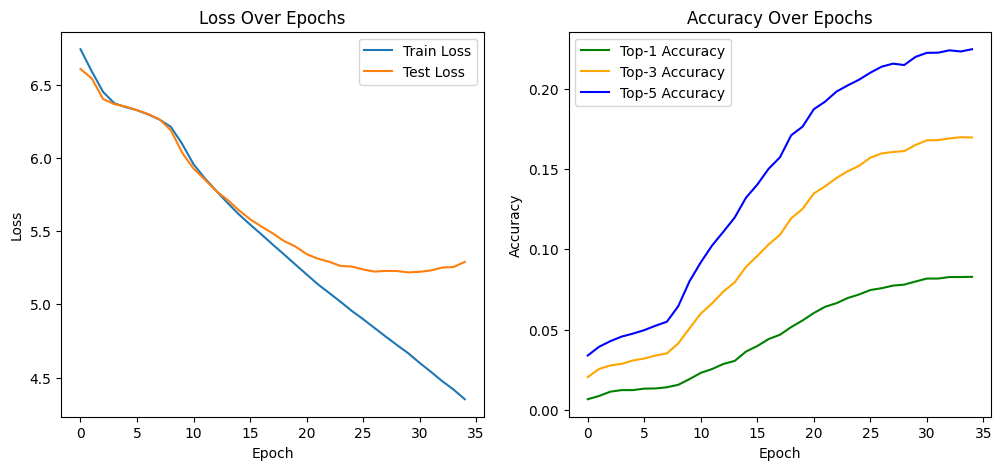

In [13]:
json_path = "../Chess_visualization/data/lichess_move_dataset.json"
vocab = build_vocab(json_path)
dataset = ChessMoveDataset(json_path, vocab)

train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
pad_idx = vocab["<PAD>"]
collate_fn = partial(collate, pad_idx=pad_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=16384,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16384,
    num_workers=12,
    pin_memory=True,
    collate_fn=collate_fn
)

model = LSTMModel(vocab_size=len(vocab))
history = train_model(
    model,
    train_loader,
    test_loader,
    epochs=100,
    patience=5,
    save_best_path="../Chess_visualization/models/lstm.pt"
)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["test_acc"], label="Top-1 Accuracy", color='green')
plt.plot(history["test_acc_top3"], label="Top-3 Accuracy", color='orange')
plt.plot(history["test_acc_top5"], label="Top-5 Accuracy", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

### combining models

The LSTM model is a good start, but I want to try combining it with my other CNN + MLP model. This way it also learns the position itself and the moves at the same time.

In [14]:
PIECE_VALUES = {
    'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 0,
    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k': 0
}

def extract_manual_features(board):
    material = sum(PIECE_VALUES.get(piece.symbol(), 0) for piece in board.piece_map().values())

    activity = (
        sum(len(board.attacks(sq)) for sq in board.pieces(chess.PAWN, chess.WHITE)) -
        sum(len(board.attacks(sq)) for sq in board.pieces(chess.PAWN, chess.BLACK))
    )

    center = (
        sum(1 for sq in [chess.D4, chess.D5, chess.E4, chess.E5] if board.is_attacked_by(chess.WHITE, sq)) -
        sum(1 for sq in [chess.D4, chess.D5, chess.E4, chess.E5] if board.is_attacked_by(chess.BLACK, sq))
    )

    legal_moves = len(list(board.legal_moves))
    turn = 1 if board.turn == chess.WHITE else -1

    development = (
        sum(1 for sq in [chess.B1, chess.G1, chess.C1, chess.F1] if board.piece_at(sq) is None) -
        sum(1 for sq in [chess.B8, chess.G8, chess.C8, chess.F8] if board.piece_at(sq) is None)
    )

    try:
        king_safety = (
            len(board.attackers(chess.BLACK, board.king(chess.WHITE))) -
            len(board.attackers(chess.WHITE, board.king(chess.BLACK)))
        )
    except:
        king_safety = 0  # fallback if a king is missing

    pawn_files_white = {chess.square_file(sq) for sq in board.pieces(chess.PAWN, chess.WHITE)}
    pawn_files_black = {chess.square_file(sq) for sq in board.pieces(chess.PAWN, chess.BLACK)}
    open_files = sum(1 for f in range(8) if f not in pawn_files_white and f not in pawn_files_black)

    return torch.tensor([
        material, activity, center, legal_moves,
        turn, development, king_safety, open_files
    ], dtype=torch.float32)


piece_to_index = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def board_to_tensor(board):
    tensor = np.zeros((12, 8, 8), dtype=np.float32)
    for square, piece in board.piece_map().items():
        row = 7 - (square // 8)   # flip row index: 0 at bottom
        col = square % 8
        idx = piece_to_index[piece.symbol()]
        tensor[idx, row, col] = 1
    return torch.tensor(tensor)   # return a Tensor directly

def moves_to_board(move_seq):
    board = chess.Board()
    for san in move_seq:
        try:
            move = board.parse_san(san)
            board.push(move)
        except:
            break  # skip illegal/invalid sequences gracefully
    return board


In [15]:
class ChessMoveDatasetCombined(Dataset):
    def __init__(self, json_path, vocab):
        self.vocab = vocab
        with open(json_path, encoding='utf-8') as f:
            self.samples = json.load(f)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        move_seq = sample["input"]
        target_move = sample["target"]

        # Encode sequence
        move_tensor = torch.tensor([self.vocab.get(m, self.vocab["<UNK>"]) for m in move_seq])
        target_idx = self.vocab.get(target_move, self.vocab["<UNK>"])
        length = len(move_tensor)

        # Reconstruct board
        board = moves_to_board(move_seq)  # ← use python-chess
        board_tensor = board_to_tensor(board)
        manual_features = extract_manual_features(board)

        return move_tensor, length, board_tensor, manual_features, target_idx

    def __len__(self):
        return len(self.samples)


In [16]:
def evaluate_combined_model(model, loader, device):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss()
    total_loss = corr1 = corr3 = corr5 = n = 0

    with torch.no_grad():
        for x, lengths, board_tensor, manual_feats, y in loader:
            x, lengths, board_tensor, manual_feats, y = (
                x.to(device, non_blocking=True),
                lengths.to(device),
                board_tensor.to(device),
                manual_feats.to(device),
                y.to(device, non_blocking=True)
            )

            logits = model(x, lengths, board_tensor, manual_feats)
            loss   = loss_fn(logits, y)
            total_loss += loss.item()

            topk = logits.topk(5, dim=1).indices
            eq   = topk.eq(y.unsqueeze(1))
            corr1 += eq[:, :1].sum().item()
            corr3 += eq[:, :3].sum().item()
            corr5 += eq.sum().item()
            n     += y.size(0)

    return total_loss / len(loader), corr1 / n, corr3 / n, corr5 / n

In [17]:
def collateCombined(batch, pad_idx):
    # Unpack all 5 fields from each item in the batch
    move_seqs, lengths, boards, features, targets = zip(*batch)

    # Pad move sequences to max length in batch
    move_seqs_padded = pad_sequence(move_seqs, batch_first=True, padding_value=pad_idx)
    lengths = torch.tensor(lengths, dtype=torch.long)
    boards = torch.stack(boards)             # (B, 12, 8, 8)
    features = torch.stack(features)         # (B, 8)
    targets = torch.tensor(targets, dtype=torch.long)

    return move_seqs_padded, lengths, boards, features, targets


In [18]:
def train_combined_model(model, train_loader, test_loader,
                epochs=20, patience=3, save_best_path=None,
                base_lr=0.001 * math.sqrt( 16384 / 1024 ), use_amp=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
    scaler    = GradScaler(enabled=use_amp)
    loss_fn   = torch.nn.CrossEntropyLoss()

    history, best_loss, no_improve = {}, float("inf"), 0
    for k in ["train_loss", "test_loss",
              "test_acc", "test_acc_top3", "test_acc_top5"]:
        history[k] = []

    for epoch in range(epochs):
        # -------- train --------
        model.train()
        running = 0.0
        for move_seq, lengths, board_tensor, manual_feats, target in train_loader:
            move_seq     = move_seq.to(device)
            lengths      = lengths.to(device)
            board_tensor = board_tensor.to(device)
            manual_feats = manual_feats.to(device)
            target       = target.to(device)

            with autocast("cuda", enabled=use_amp):
                logits = model(move_seq, lengths, board_tensor, manual_feats)
                loss   = loss_fn(logits, target
        )

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=use_amp):
                logits = model(move_seq, lengths, board_tensor, manual_feats)
                loss   = loss_fn(logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()

        avg_train = running / len(train_loader)

        # -------- eval ---------
        test_loss, acc1, acc3, acc5 = evaluate_combined_model(model, test_loader, device)
        history["train_loss"].append(avg_train)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(acc1)
        history["test_acc_top3"].append(acc3)
        history["test_acc_top5"].append(acc5)

        print(f"Epoch {epoch+1}: "
              f"Train {avg_train:.4f} | Test {test_loss:.4f} "
              f"| Top-1 {acc1:.2%} Top-3 {acc3:.2%} Top-5 {acc5:.2%}")


        # -------- early stop ---
        if test_loss < best_loss:
            best_loss, no_improve = test_loss, 0
            if save_best_path:
                torch.save(model.state_dict(), save_best_path)
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping (no improvement {patience} epochs)")
                break

    return history

In [19]:
class CNN_MLP_FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(12, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Flatten()
        )

        self.mlp = nn.Sequential(
            nn.Linear(8, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU()
        )

    def forward(self, x_image, x_manual):
        x_cnn = self.cnn(x_image)          # (B, 8192)
        x_mlp = self.mlp(x_manual)         # (B, 128)
        return torch.cat((x_cnn, x_mlp), dim=1)  # (B, 8320)


In [20]:
class LSTMPlusPositionModel(nn.Module):
    def __init__(self, vocab_size,
                 embedding_dim=256,
                 hidden_dim=512,
                 num_layers=3,
                 dropout=0.2):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.feature_extractor = CNN_MLP_FeatureExtractor()  # outputs (B, 8320)

        combined_dim = hidden_dim + 8320

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 512), nn.ReLU(),
            nn.Linear(512, vocab_size)
        )

    def forward(self, move_seq, lengths, board_tensor, manual_feats):
        emb = self.embedding(move_seq)

        # Pack padded sequence for variable-length input
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)   # h_n: (num_layers, B, hidden)
        lstm_out = h_n[-1]                # (B, hidden)

        # Board context vector (CNN + MLP)
        context = self.feature_extractor(board_tensor, manual_feats)  # (B, 8320)

        # Concatenate both
        x = torch.cat((lstm_out, context), dim=1)
        return self.fc(x)   # (B, vocab_size)


Using device: cuda
Epoch 1: Train 7.1399 | Test 6.5915 | Top-1 0.83% Top-3 2.30% Top-5 3.45%
Epoch 2: Train 6.5662 | Test 6.5325 | Top-1 1.10% Top-3 2.45% Top-5 3.78%
Epoch 3: Train 6.3900 | Test 6.3411 | Top-1 1.22% Top-3 2.99% Top-5 4.75%
Epoch 4: Train 6.2541 | Test 6.2039 | Top-1 1.55% Top-3 4.03% Top-5 6.24%
Epoch 5: Train 6.0299 | Test 5.9960 | Top-1 1.79% Top-3 5.05% Top-5 8.02%
Epoch 6: Train 5.8927 | Test 5.8645 | Top-1 2.29% Top-3 6.02% Top-5 9.29%
Epoch 7: Train 5.7740 | Test 5.7562 | Top-1 3.02% Top-3 7.24% Top-5 10.84%
Epoch 8: Train 5.6376 | Test 5.6105 | Top-1 3.91% Top-3 9.15% Top-5 13.40%
Epoch 9: Train 5.4953 | Test 5.4963 | Top-1 4.94% Top-3 11.20% Top-5 15.86%
Epoch 10: Train 5.3689 | Test 5.4143 | Top-1 5.68% Top-3 12.50% Top-5 17.41%
Epoch 11: Train 5.2550 | Test 5.3643 | Top-1 6.21% Top-3 13.44% Top-5 18.71%
Epoch 12: Train 5.1597 | Test 5.2963 | Top-1 6.61% Top-3 14.51% Top-5 19.86%
Epoch 13: Train 5.0711 | Test 5.2364 | Top-1 7.13% Top-3 15.23% Top-5 20.67%
Epo

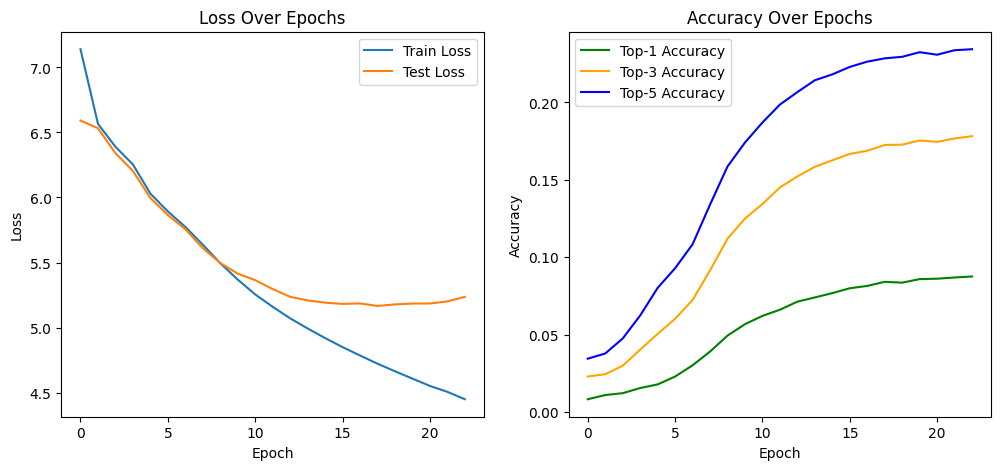

In [21]:
json_path = "../Chess_visualization/data/lichess_move_dataset.json"
vocab = build_vocab(json_path)
dataset = ChessMoveDatasetCombined(json_path, vocab)

train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
pad_idx = vocab["<PAD>"]
collate_fn = partial(collateCombined, pad_idx=pad_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=4092,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4092,
    num_workers=12,
    pin_memory=True,
    collate_fn=collate_fn
)

model = LSTMPlusPositionModel(vocab_size=len(vocab))
history = train_combined_model(
    model,
    train_loader,
    test_loader,
    epochs=100,
    patience=5,
    save_best_path="../Chess_visualization/models/lstm.pt"
)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["test_acc"], label="Top-1 Accuracy", color='green')
plt.plot(history["test_acc_top3"], label="Top-3 Accuracy", color='orange')
plt.plot(history["test_acc_top5"], label="Top-5 Accuracy", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()